# CNN: Regression experiments

script: jupyter-gpu.sbatch  
partition: gpu  
conda env: torch-ni-ny  
data: /scratch/groups/jyeatman/samjohns-projects/data 
  
notable changes:
- add train-test split
- (network) add extra final fully connected layer
- (network) change fc nonlinearity from relu to elu

## Step 1: Prepare Data

In [62]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# these are required for defining the regession ImageFolder
from typing import Dict, Any
from torchvision import datasets

import pandas as pd
import numpy as np

In [2]:
import os, sys, pickle

import struct
from array import array
from os import path

import png
from PIL import Image
from PIL import ImageOps

In [63]:
# user-defined helper functions for visualization and training
import utils

In [3]:
proj_dir = '/scratch/groups/jyeatman/samjohns-projects'
image_subdir = '/data/fsa-data/images/images-thickness-sphere-processed'
image_dir = proj_dir + image_subdir
os.chdir(proj_dir)

In [4]:
# dataset specific directories
data_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
pheno_dir = '/scratch/groups/jyeatman/samjohns-projects/data/hbn-reading-age-data'
label_dir = data_dir + '/labels'
os.listdir(pheno_dir)

['agef.pkl',
 'wiat_reading.csv',
 'nonblank_inds.pkl',
 'hbn_ages_blanks.csv',
 'readf.pkl']

In [64]:
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms

class CustomImageDataset(Dataset):
    """ Custom dataset, like ImageFolder, works with arbitrary image labels.
        Labels should be a .csv in the format:
            image1filename.png, image1label
            image2filename.png, image2label
            ...
        Useful for regression; circumvents ImageFolder classification scheme
        which requires that images be sorted into subfolders corresponding to class names.
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [21]:
# helper function to be used as transform (typically from uint8 to float)
# useful because inputs must have the same datatype as weights of the n.n.

class ToFloat(object):
    """Converts the datatype in sample to torch.float32 datatype."""

    def __call__(self, target):
        target_tensor = torch.tensor(target)
        return target_tensor.to(torch.float32)

## This section formats the dataset
- It is unnecessary to execute unless preparing a new dataset
- (In which case, new image directories, pheno files, and label output files should be set)

In [6]:
# first read in filenames and create a filename dataframe

image_filenames = os.listdir(image_dir)

In [16]:
# strip EID from image filenames; first 16 characters of filename string
EID_length = 16
sub_filenames = [name[:EID_length] for name in image_filenames]
assert len(sub_filenames) == len(image_filenames)

In [66]:
d = {'EID': sub_filenames, 'Filename': image_filenames}

In [67]:
filename_df = pd.DataFrame(d)

In [68]:
filename_df.head()

,EID,Filename
0,sub-NDARKB614KGY,sub-NDARKB614KGY.fsa.lh.thickness--69.91--2.30...
1,sub-NDARGP399TDM,sub-NDARGP399TDM.fsa.lh.thickness--64.15--0.05...
2,sub-NDARJT615WM7,sub-NDARJT615WM7.fsa.lh.thickness--69.85--1.94...
3,sub-NDARCZ947WU5,sub-NDARCZ947WU5.fsa.lh.thickness--66.48-4.59-...
4,sub-NDARPL215MTH,sub-NDARPL215MTH.fsa.lh.thickness--61.84--3.62...


In [72]:
age_df = pd.read_csv(pheno_dir+'/hbn_ages_blanks.csv', header=None)

In [73]:
age_df.columns = ['EID', 'Age']
age_df.head()

,EID,Age
0,sub-NDARAA075AMK,7
1,sub-NDARAA536PTU,12
2,sub-NDARAA948VFH,8
3,sub-NDARAB055BPR,11
4,sub-NDARAB348EWR,6


In [74]:
age_df_noblanks = age_df[age_df.Age != ' ']

In [75]:
pheno_df = pd.merge(filename_df, age_df_noblanks, on='EID', how='left')

In [76]:
# filter out nan's (for which EID didn't appear in Age data)
pheno_df = pheno_df.dropna()

In [79]:
# save df as .csv
label_dir = data_dir + '/labels'
if not os.path.exists(label_dir):
    os.makedirs(label_dir)
pheno_df_nosub = pheno_df[['Filename', 'Age']]
pheno_df_nosub

,Filename,Age
0,sub-NDARKB614KGY.fsa.lh.thickness--69.91--2.30...,11
3,sub-NDARCZ947WU5.fsa.lh.thickness--66.48-4.59-...,9
4,sub-NDARPL215MTH.fsa.lh.thickness--61.84--3.62...,10
5,sub-NDARRW100AU0.fsa.lh.thickness--67.39--2.71...,8
7,sub-NDARKF615JNZ.fsa.lh.thickness--61.16-0.99-...,10
...,...,...
23889,sub-NDARCB627KDN.fsa.lh.thickness--66.79-2.73-...,11
23890,sub-NDARBW525JHY.fsa.lh.thickness--62.15--4.96...,5
23893,sub-NDARUX315PE6.fsa.lh.thickness--66.98-1.74-...,14
23894,sub-NDARKL327YDQ.fsa.lh.thickness--65.66-2.39-...,16


In [80]:
pheno_df_nosub.to_csv(label_dir+'/age_thickness_sphere_labels.csv', index=False)

In [81]:
os.listdir(label_dir)

['age_labels.csv', 'age_thickness_sphere_labels.csv']

## Load MNIST dataset for testing, if desired
- optionally loads MNIST database for testing

In [18]:
# MNIST location
proj_dir = '/scratch/groups/jyeatman/samjohns-projects'
mnist_subdir = 'data/MNIST/mnist_png'
mnist_dir = os.path.join(proj_dir, mnist_subdir)
mnist_training_dir = os.path.join(mnist_dir, 'training')
mnist_testing_dir = os.path.join(mnist_dir, 'testing')

In [22]:
mnist_train = CustomImageDataset(f'{mnist_training_dir}/training_labels.csv', f'{mnist_training_dir}/all', transform=transforms.ConvertImageDtype(torch.float32), target_transform=ToFloat())
mnist_test = CustomImageDataset(f'{mnist_testing_dir}/testing_labels.csv', f'{mnist_testing_dir}/all', transform=transforms.ConvertImageDtype(torch.float32), target_transform=ToFloat())

In [51]:
# for MNIST
mnist_batch_size = 64

mnist_trainloader = DataLoader(mnist_train, batch_size=mnist_batch_size, shuffle=True)
mnist_testloader = DataLoader(mnist_test, batch_size=mnist_batch_size, shuffle=False)

## Load dataset
- Continue from this point if images and label files are already created

In [53]:
# load labels to check for correct formatting
test_df = pd.read_csv(f'{label_dir}/age_thickness_sphere_labels.csv')

In [54]:
test_df

,Filename,Age
0,sub-NDARKB614KGY.fsa.lh.thickness--69.91--2.30...,11
1,sub-NDARCZ947WU5.fsa.lh.thickness--66.48-4.59-...,9
2,sub-NDARPL215MTH.fsa.lh.thickness--61.84--3.62...,10
3,sub-NDARRW100AU0.fsa.lh.thickness--67.39--2.71...,8
4,sub-NDARKF615JNZ.fsa.lh.thickness--61.16-0.99-...,10
...,...,...
15638,sub-NDARCB627KDN.fsa.lh.thickness--66.79-2.73-...,11
15639,sub-NDARBW525JHY.fsa.lh.thickness--62.15--4.96...,5
15640,sub-NDARUX315PE6.fsa.lh.thickness--66.98-1.74-...,14
15641,sub-NDARKL327YDQ.fsa.lh.thickness--65.66-2.39-...,16


In [55]:
# load total dataset
thickness = CustomImageDataset(f'{label_dir}/age_thickness_sphere_labels.csv', image_dir, transform=transforms.ConvertImageDtype(torch.float32), target_transform=ToFloat())

In [56]:
# create random split into train and test sets
nsamples = len(thickness)
indices = list(range(nsamples))
ntest = nsamples // 10
ntrain = nsamples - ntest
test_indices = list(np.random.choice(indices, size=ntest, replace=False))
train_indices = list(set(indices) - set(test_indices))
(len(test_indices), len(train_indices))

(1564, 14079)

In [57]:
thickness_train = torch.utils.data.Subset(thickness, train_indices) 
thickness_test = torch.utils.data.Subset(thickness, test_indices) 

In [58]:
# create dataloaders for convenient batching
batch_size = 64

trainloader = DataLoader(thickness_train, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
testloader = DataLoader(thickness_test, batch_size=batch_size, shuffle=False, num_workers=3, pin_memory=True)

In [59]:
train_batch = next(iter(trainloader))

In [60]:
train_batch[1].dtype

torch.float32

Classes: tensor([10., 16., 10., 11.,  6.])


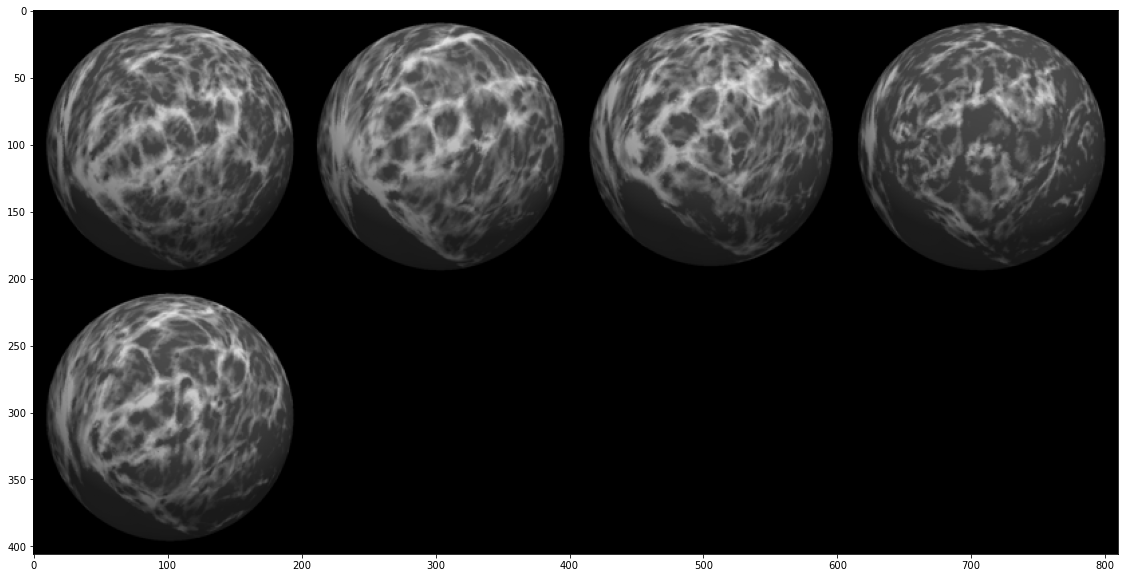

In [61]:
# visualize images

import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # normalization may be required in some cases, but not here
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize = (20,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch (nrows images per row)
print(f'Classes: {classes[:5]}')
out = torchvision.utils.make_grid(inputs[:5], nrow=4)

imshow(out)

In [19]:
train_batch = next(iter(trainloader))

In [20]:
train_batch[0].dtype, train_batch[0].shape

(torch.float32, torch.Size([64, 1, 200, 200]))

## Model training (for testing Freeview image CNN)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [47]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(1, 32, 4, padding='same')
        self.l2 = nn.Conv2d(32, 64, 4, padding='same')
        self.m1 = nn.MaxPool2d(4, stride=2)
        self.l3 = nn.Conv2d(64, 128, 4, padding='same')
        self.l4 = nn.Conv2d(128, 128, 4, padding='same')
        self.m2 = nn.MaxPool2d(4, stride=2)
        self.l5 = nn.Conv2d(128, 128, 4, padding='same')
        self.l6 = nn.Conv2d(128, 128, 4, padding='same')
        self.m3 = nn.MaxPool2d(4, stride=2)
        self.l7 = nn.Conv2d(128, 128, 4, padding='same')
        self.l8 = nn.Conv2d(128, 64, 4, padding='same')
        self.m4 = nn.MaxPool2d(4, stride=2)
        self.fc1 = nn.Linear(6400, 100)
        self.fc2 = nn.Linear(100, 24)
        self.fc3 = nn.Linear(24, 1)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x)) 
        x = self.m1(x) 
        x = F.relu(self.l3(x)) 
        x = F.relu(self.l4(x)) 
        x = self.m2(x) 
        x = F.relu(self.l5(x)) 
        x = F.relu(self.l6(x)) 
        x = self.m3(x) 
        x = F.relu(self.l7(x)) 
        x = F.relu(self.l8(x)) 
        x = self.m4(x) 
        x = torch.flatten(x, 1) # do not flatten batch dimensions
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        return x

In [48]:
from torchsummary import summary

In [49]:
cnn = ConvNet().to(device)

In [50]:
summary(cnn, (1, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             544
            Conv2d-2         [-1, 64, 200, 200]          32,832
         MaxPool2d-3           [-1, 64, 99, 99]               0
            Conv2d-4          [-1, 128, 99, 99]         131,200
            Conv2d-5          [-1, 128, 99, 99]         262,272
         MaxPool2d-6          [-1, 128, 48, 48]               0
            Conv2d-7          [-1, 128, 48, 48]         262,272
            Conv2d-8          [-1, 128, 48, 48]         262,272
         MaxPool2d-9          [-1, 128, 23, 23]               0
           Conv2d-10          [-1, 128, 23, 23]         262,272
           Conv2d-11           [-1, 64, 23, 23]         131,136
        MaxPool2d-12           [-1, 64, 10, 10]               0
           Linear-13                  [-1, 100]         640,100
           Linear-14                   

## Training cell below
- caution: can take a long time to execute
- loading data (in epoch one) can take a long time;
- subsequent epochs go faster

In [28]:
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
batch_sizes = [4, 8, 16, 32, 64, 128]
weight_decays = [0] #[0, 1e-1, 1e-2]

In [29]:
model = cnn
loss_fn = nn.MSELoss() # note that we use MSE, somewhat atypical for cnn
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [ ]:
# loop over several training models -- grid search
epochs = 50
for lr in lrs:
    for batch_size in batch_sizes:
        for wd in weight_decays:
            print(f'lr: {lr}, batch size: {batch_size}')
            # create dataloaders for convenient batching
            trainloader = DataLoader(thickness_train, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
            testloader = DataLoader(thickness_test, batch_size=batch_size, shuffle=False, num_workers=3, pin_memory=True)
            
            model = ConvNet().to(device)
            loss_fn = nn.MSELoss() # note that we use MSE, somewhat atypical for cnn
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            
            # train here
            utils.train(model, loss_fn, optimizer, trainloader, testloader, epochs=epochs)

lr: 0.01, batch size: 4
Epoch 1
-------------------------------
loss: 81.081207  [    0/14079]
loss: 19.687302  [  400/14079]
loss: 9.949963  [  800/14079]
loss: 29.356447  [ 1200/14079]
loss: 19.951439  [ 1600/14079]
loss: 4.584120  [ 2000/14079]
loss: 6.987829  [ 2400/14079]
loss: 16.757366  [ 2800/14079]
loss: 4.704713  [ 3200/14079]
loss: 12.585474  [ 3600/14079]
loss: 17.839809  [ 4000/14079]
loss: 25.270164  [ 4400/14079]
loss: 15.143194  [ 4800/14079]
loss: 15.838172  [ 5200/14079]
loss: 18.213490  [ 5600/14079]
loss: 19.489719  [ 6000/14079]
loss: 30.879971  [ 6400/14079]
loss: 15.536287  [ 6800/14079]
loss: 46.172943  [ 7200/14079]
loss: 16.972393  [ 7600/14079]
loss: 10.605954  [ 8000/14079]
loss: 13.165062  [ 8400/14079]
loss: 26.987751  [ 8800/14079]
loss: 36.245872  [ 9200/14079]
loss: 40.338146  [ 9600/14079]
loss: 8.218081  [10000/14079]
loss: 4.845250  [10400/14079]
loss: 12.187096  [10800/14079]
loss: 6.409331  [11200/14079]
loss: 10.881808  [11600/14079]
loss: 22.0273

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 14.239926 

Epoch 2
-------------------------------
loss: 25.742218  [    0/14079]
loss: 0.542210  [  400/14079]
loss: 24.129307  [  800/14079]
loss: 6.455875  [ 1200/14079]
loss: 7.670615  [ 1600/14079]
loss: 9.347753  [ 2000/14079]
loss: 6.696239  [ 2400/14079]
loss: 6.356143  [ 2800/14079]
loss: 13.187519  [ 3200/14079]
loss: 9.596081  [ 3600/14079]
loss: 9.873613  [ 4000/14079]
loss: 11.505400  [ 4400/14079]
loss: 18.322639  [ 4800/14079]
loss: 4.633690  [ 5200/14079]
loss: 9.365036  [ 5600/14079]
loss: 20.806091  [ 6000/14079]
loss: 5.888633  [ 6400/14079]
loss: 19.797592  [ 6800/14079]
loss: 11.347106  [ 7200/14079]
loss: 4.729688  [ 7600/14079]
loss: 6.906699  [ 8000/14079]
loss: 13.676929  [ 8400/14079]
loss: 16.860920  [ 8800/14079]
loss: 15.012154  [ 9200/14079]
loss: 14.933966  [ 9600/14079]
loss: 8.071037  [10000/14079]
loss: 6.233225  [10400/14079]
loss: 10.695944  [10800/14079]
loss: 32.272316  [11200/14079]
loss: 23.946007  [11600/14079]
loss: 21.

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 12.812575 

Epoch 2
-------------------------------
loss: 14.952172  [    0/14079]
loss: 12.360204  [  800/14079]
loss: 20.639843  [ 1600/14079]
loss: 17.570349  [ 2400/14079]
loss: 33.853668  [ 3200/14079]
loss: 21.591124  [ 4000/14079]
loss: 15.297031  [ 4800/14079]
loss: 13.137510  [ 5600/14079]
loss: 13.341375  [ 6400/14079]
loss: 12.592282  [ 7200/14079]
loss: 12.599735  [ 8000/14079]
loss: 6.182043  [ 8800/14079]
loss: 26.405622  [ 9600/14079]
loss: 9.205328  [10400/14079]
loss: 8.758377  [11200/14079]
loss: 8.956232  [12000/14079]
loss: 13.109678  [12800/14079]
loss: 14.745300  [13600/14079]
Test Error: 
 Avg loss: 13.197433 

Epoch 3
-------------------------------
loss: 11.123493  [    0/14079]
loss: 15.520210  [  800/14079]
loss: 16.605190  [ 1600/14079]
loss: 13.391623  [ 2400/14079]
loss: 13.110610  [ 3200/14079]
loss: 21.182713  [ 4000/14079]
loss: 6.337274  [ 4800/14079]
loss: 18.454887  [ 5600/14079]
loss: 16.267456  [ 6400/14079]
loss: 7.844733  

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 12.920488 

Epoch 2
-------------------------------


/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 12.510866  [    0/14079]
loss: 14.637639  [ 1600/14079]
loss: 13.657116  [ 3200/14079]
loss: 13.492534  [ 4800/14079]
loss: 11.174072  [ 6400/14079]
loss: 17.415993  [ 8000/14079]
loss: 7.438267  [ 9600/14079]
loss: 19.136501  [11200/14079]
loss: 11.198294  [12800/14079]
Test Error: 
 Avg loss: 12.683477 

Epoch 3
-------------------------------
loss: 12.878307  [    0/14079]
loss: 12.929250  [ 1600/14079]
loss: 14.640228  [ 3200/14079]
loss: 8.337545  [ 4800/14079]
loss: 18.189466  [ 6400/14079]
loss: 11.271410  [ 8000/14079]
loss: 18.664211  [ 9600/14079]
loss: 11.074932  [11200/14079]
loss: 13.835152  [12800/14079]
Test Error: 
 Avg loss: 12.735194 

Epoch 4
-------------------------------
loss: 10.784309  [    0/14079]
loss: 16.559788  [ 1600/14079]
loss: 12.096512  [ 3200/14079]
loss: 9.904733  [ 4800/14079]
loss: 13.424443  [ 6400/14079]
loss: 7.255287  [ 8000/14079]
loss: 15.784027  [ 9600/14079]
loss: 11.116256  [11200/14079]
loss: 12.600750  [12800/14079]
Test Error: 
 A

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 13.074133 

Epoch 2
-------------------------------


/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 16.049343  [    0/14079]
loss: 22.255356  [ 3200/14079]
loss: 13.699172  [ 6400/14079]
loss: 12.815899  [ 9600/14079]
loss: 11.755364  [12800/14079]
Test Error: 
 Avg loss: 16.763583 

Epoch 3
-------------------------------
loss: 18.990223  [    0/14079]
loss: 11.650673  [ 3200/14079]
loss: 13.075475  [ 6400/14079]
loss: 5.173207  [ 9600/14079]
loss: 14.398224  [12800/14079]
Test Error: 
 Avg loss: 16.365368 

Epoch 4
-------------------------------
loss: 5.210934  [    0/14079]
loss: 13.789834  [ 3200/14079]
loss: 144.750000  [ 6400/14079]
loss: 141.437500  [ 9600/14079]
loss: 161.281250  [12800/14079]
Test Error: 
 Avg loss: 151.931669 

Epoch 5
-------------------------------
loss: 153.875000  [    0/14079]
loss: 141.562500  [ 3200/14079]
loss: 149.843750  [ 6400/14079]
loss: 141.000000  [ 9600/14079]
loss: 133.906250  [12800/14079]
Test Error: 
 Avg loss: 151.931669 

Epoch 6
-------------------------------
loss: 175.218750  [    0/14079]
loss: 180.156250  [ 3200/14079]
loss

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 12.646787 

Epoch 2
-------------------------------
loss: 13.506437  [    0/14079]
loss: 14.178139  [ 6400/14079]
loss: 7.664567  [12800/14079]
Test Error: 
 Avg loss: 12.844346 

Epoch 3
-------------------------------
loss: 14.035378  [    0/14079]
loss: 14.458496  [ 6400/14079]
loss: 13.401246  [12800/14079]
Test Error: 
 Avg loss: 12.643399 

Epoch 4
-------------------------------
loss: 15.424352  [    0/14079]
loss: 9.422689  [ 6400/14079]
loss: 15.479586  [12800/14079]
Test Error: 
 Avg loss: 12.770574 

Epoch 5
-------------------------------
loss: 12.436075  [    0/14079]
loss: 13.365879  [ 6400/14079]
loss: 15.274039  [12800/14079]
Test Error: 
 Avg loss: 12.647674 

Epoch 6
-------------------------------
loss: 19.753246  [    0/14079]
loss: 8.863755  [ 6400/14079]
loss: 14.387441  [12800/14079]
Test Error: 
 Avg loss: 12.712737 

Epoch 7
-------------------------------
loss: 13.163505  [    0/14079]
loss: 15.226436  [ 6400/14079]
loss: 12.708784  [12

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 12.612336 

Epoch 2
-------------------------------
loss: 13.031532  [    0/14079]
loss: 15.062075  [12800/14079]
Test Error: 
 Avg loss: 12.749688 

Epoch 3
-------------------------------
loss: 13.696523  [    0/14079]
loss: 17.971748  [12800/14079]
Test Error: 
 Avg loss: 12.606507 

Epoch 4
-------------------------------
loss: 12.928993  [    0/14079]
loss: 13.477367  [12800/14079]
Test Error: 
 Avg loss: 12.808318 

Epoch 5
-------------------------------
loss: 10.644852  [    0/14079]
loss: 16.668400  [12800/14079]
Test Error: 
 Avg loss: 12.591672 

Epoch 6
-------------------------------
loss: 13.751131  [    0/14079]
loss: 12.558729  [12800/14079]
Test Error: 
 Avg loss: 12.601009 

Epoch 7
-------------------------------
loss: 13.371203  [    0/14079]
loss: 15.157677  [12800/14079]
Test Error: 
 Avg loss: 12.857058 

Epoch 8
-------------------------------
loss: 9.901796  [    0/14079]
loss: 15.547888  [12800/14079]
Test Error: 
 Avg loss: 12.589036 


In [47]:
# comparison to predicting average
test_df.head()

,Filename,Age
0,sub-NDARKB614KGY.fsa.lh.thickness--69.91--2.30...,11
1,sub-NDARCZ947WU5.fsa.lh.thickness--66.48-4.59-...,9
2,sub-NDARPL215MTH.fsa.lh.thickness--61.84--3.62...,10
3,sub-NDARRW100AU0.fsa.lh.thickness--67.39--2.71...,8
4,sub-NDARKF615JNZ.fsa.lh.thickness--61.16-0.99-...,10


In [33]:
m = test_df.Age.mean()
s = test_df.Age.std()
print(f'Age: (mean, std) = ({m}, {s})')

Age: (mean, std) = (10.811992584542606, 3.661851898546048)


# Vestigal: record of training on neuropythy images

In [37]:
# set appropriate (three-channel (rgb)) dataloaders for transfer cnn
dataloaders = {'train': trainl_rgb, 'val': testl_rgb}
dataset_sizes = {'train': ntrain, 'val': ntest}

In [38]:
# easiest
len(dataloaders['val'].dataset.indices)

199

In [39]:
dataset_sizes = {}
for phase, dl in dataloaders.items():
    dataset_sizes[phase] = len(dl.dataset.indices)

In [40]:
dataset_sizes = {phase: len(dl.dataset.indices) for phase, dl in dataloaders.items()}

In [41]:
dataset_sizes

{'train': 1798, 'val': 199}

In [18]:
def train_model(model, criterion, optimizer, dataloaders, scheduler, num_epochs=25):

    since = time.time()

    dataset_sizes = {phase: len(dl.dataset.indices) for phase, dl in dataloaders.items()}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_accs.append(epoch_acc)
            else:
                val_accs.append(epoch_acc)
                

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, val_accs

In [43]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, dataloaders, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3485 Acc: 0.9054
val Loss: 0.3236 Acc: 0.9118

Epoch 1/24
----------
train Loss: 0.3177 Acc: 0.9059
val Loss: 0.3252 Acc: 0.9118

Epoch 2/24
----------
train Loss: 0.2837 Acc: 0.9059
val Loss: 0.3270 Acc: 0.9118

Epoch 3/24
----------
train Loss: 0.2347 Acc: 0.9110
val Loss: 0.3580 Acc: 0.9076

Epoch 4/24
----------
train Loss: 0.1603 Acc: 0.9357
val Loss: 0.4065 Acc: 0.8908

Epoch 5/24
----------
train Loss: 0.0871 Acc: 0.9716
val Loss: 0.9061 Acc: 0.9118

Epoch 6/24
----------
train Loss: 0.0595 Acc: 0.9776
val Loss: 0.6102 Acc: 0.8151

Epoch 7/24
----------
train Loss: 0.0214 Acc: 0.9949
val Loss: 0.6022 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.0119 Acc: 0.9972
val Loss: 0.6168 Acc: 0.8866

Epoch 9/24
----------
train Loss: 0.0116 Acc: 0.9981
val Loss: 0.6860 Acc: 0.9118

Epoch 10/24
----------
train Loss: 0.0102 Acc: 0.9972
val Loss: 0.6045 Acc: 0.8866

Epoch 11/24
----------
train Loss: 0.0075 Acc: 0.9986
val Loss: 0.6538 Acc: 0.9034

Ep

In [98]:
# summarize
from torchsummary import summary

In [99]:
xs, ys = next(iter(trainl_rgb)) # easiest way to get a random batch from a dataloader

In [100]:
xs.shape

torch.Size([8, 3, 400, 400])

In [101]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [102]:
summary(model_ft, (3, 400, 400)) # do not include batch dimension when specifying input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           9,408
       BatchNorm2d-2         [-1, 64, 200, 200]             128
              ReLU-3         [-1, 64, 200, 200]               0
         MaxPool2d-4         [-1, 64, 100, 100]               0
            Conv2d-5         [-1, 64, 100, 100]          36,864
       BatchNorm2d-6         [-1, 64, 100, 100]             128
              ReLU-7         [-1, 64, 100, 100]               0
            Conv2d-8         [-1, 64, 100, 100]          36,864
       BatchNorm2d-9         [-1, 64, 100, 100]             128
             ReLU-10         [-1, 64, 100, 100]               0
       BasicBlock-11         [-1, 64, 100, 100]               0
           Conv2d-12         [-1, 64, 100, 100]          36,864
      BatchNorm2d-13         [-1, 64, 100, 100]             128
             ReLU-14         [-1, 64, 1

## TO DO: Grid search over training hyperparameters

In [24]:
lrs = [0.1, 0.01, 1e-3, 1e-4, 5e-5]
batch_sizes = [4, 8, 16, 32, 64]

## v2. cnn from scratch

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(1, 4, 4, padding='same')
        self.l2 = nn.Conv2d(4, 16, 4, padding='same')
        self.m1 = nn.MaxPool2d(4, stride=2)
        self.l3 = nn.Conv2d(16, 64, 4, padding='same')
        self.l4 = nn.Conv2d(64, 128, 4, padding='same')
        self.m2 = nn.MaxPool2d(4, stride=2)
        self.l5 = nn.Conv2d(128, 128, 4, padding='same')
        self.l6 = nn.Conv2d(128, 64, 4, padding='same')
        self.m3 = nn.MaxPool2d(4, stride=2)
        self.l7 = nn.Conv2d(64, 32, 4, padding='same')
        self.l8 = nn.Conv2d(32, 32, 4, padding='same')
        self.l9 = nn.Conv2d(32, 32, 4, padding='same')
        self.m4 = nn.MaxPool2d(4, stride=2)
        self.l10 = nn.Conv2d(32, 32, 4, padding='same')
        self.l11 = nn.Conv2d(32, 32, 4, padding='same')
        self.l12 = nn.Conv2d(32, 32, 4, padding='same')
        self.m5 = nn.MaxPool2d(4, stride=2)
        self.fc1 = nn.Linear(32*10*10, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x)) 
        x = self.m1(x) 
        x = F.relu(self.l3(x)) 
        x = F.relu(self.l4(x)) 
        x = self.m2(x) 
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x)) 
        x = self.m3(x) 
        x = F.relu(self.l7(x)) 
        x = F.relu(self.l8(x)) 
        x = F.relu(self.l9(x)) 
        x = self.m4(x) 
        x = F.relu(self.l10(x))
        x = F.relu(self.l11(x))
        x = F.relu(self.l12(x))
        x = self.m5(x)
        x = torch.flatten(x, 1) # do not flatten batch dimensions
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
cnn = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [22]:
from torchsummary import summary

In [23]:
summary(cnn, (1, 400, 400))

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [108]:
cnn = cnn.to(device) # required before using train function; should change?

In [112]:
xtest, ytest = next(iter(trainloader))

In [114]:
# sanity check
cnn(xtest.to(device))

tensor([[-0.1394,  0.0894],
        [-0.1395,  0.0894],
        [-0.1391,  0.0891],
        [-0.1393,  0.0894],
        [-0.1389,  0.0892],
        [-0.1393,  0.0899],
        [-0.1394,  0.0890],
        [-0.1389,  0.0894]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [115]:
xtest.shape

torch.Size([8, 1, 400, 400])

In [95]:
dataloaders_gray = {'train': trainloader, 'val': testloader}

In [126]:
cnn_ft, train_accs, val_accs = train_model(cnn, criterion, optimizer, dataloaders_gray, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4042 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 1/24
----------
train Loss: 0.3842 Acc: 0.8721
val Loss: 0.3695 Acc: 0.8794

Epoch 2/24
----------
train Loss: 0.3832 Acc: 0.8721
val Loss: 0.3713 Acc: 0.8794

Epoch 3/24
----------
train Loss: 0.3840 Acc: 0.8721
val Loss: 0.3714 Acc: 0.8794

Epoch 4/24
----------
train Loss: 0.3817 Acc: 0.8721
val Loss: 0.3691 Acc: 0.8794

Epoch 5/24
----------
train Loss: 0.3831 Acc: 0.8721
val Loss: 0.3686 Acc: 0.8794

Epoch 6/24
----------
train Loss: 0.3836 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 7/24
----------
train Loss: 0.3837 Acc: 0.8721
val Loss: 0.3683 Acc: 0.8794

Epoch 8/24
----------
train Loss: 0.3839 Acc: 0.8721
val Loss: 0.3705 Acc: 0.8794

Epoch 9/24
----------
train Loss: 0.3833 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 10/24
----------
train Loss: 0.3838 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 11/24
----------
train Loss: 0.3834 Acc: 0.8721
val Loss: 0.3687 Acc: 0.8794

Ep